# Installing the necessary libraries

In [ ]:
!pip install xgboost lightgbm catboost
!pip install category_encoders

# Import libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from math import sqrt
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import permutation_importance
import seaborn as sns
import os
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.base import RegressorMixin, BaseEstimator

In [ ]:
from category_encoders import BinaryEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

# Importing a data set

In [ ]:
print(os.listdir('drive/MyDrive/math_basis_of_ai/RestaurantRevenuePrediction'))
PATH = 'drive/MyDrive/math_basis_of_ai/RestaurantRevenuePrediction/'
df_train = pd.read_csv(f'{PATH}train.csv', parse_dates=['Open Date'])
df_test = pd.read_csv(f'{PATH}test.csv', parse_dates=['Open Date'])

['train.csv', 'test.csv', 'sampleSubmission.csv']


# File descriptions
* train.csv - the training set. Use this dataset for training your model.
* test.csv - the test set. To deter manual "guess" predictions, Kaggle has supplemented the test set with additional "ignored" data. These are not counted in the scoring.
* sampleSubmission.csv - a sample submission file in the correct format
# Descriptions of Loan Data
* Id : Restaurant id.
* Open Date : opening date for a restaurant
* City : City that the restaurant is in. Note that there are unicode in the names.
* City Group: Type of the city. Big cities, or Other.
* Type: Type of the restaurant. FC: Food Court, IL: Inline, DT: Drive Thru, MB: Mobile
* P1, P2 - P37: There are three categories of these obfuscated data. Demographic data are gathered from third party providers with GIS systems. These include population in any given area, age and gender distribution, development scales. Real estate data mainly relate to the m2 of the location, front facade of the location, car park availability. Commercial data mainly include the existence of points of interest including schools, banks, other QSR operators.
* Revenue: The revenue column indicates a (transformed) revenue of the restaurant in a given year and is the target of predictive analysis. Please note that the values are transformed so they don't mean real dollar values.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Model evaluation function

In [ ]:
def score(model, X_train, y_train, X_valid = [], y_valid = []):
    rmse = sqrt(mean_squared_error(np.square(np.exp(y_train)), np.square(np.exp(model.predict(X_train)))))
    score = [rmse, model.score(X_train, y_train)]

    # If validation data is provided, calculate validation RMSE
    if len(X_valid) != 0 and len(y_valid) != 0:
        score.append(sqrt(mean_squared_error(np.square(np.exp(y_valid)), np.square(np.exp(model.predict(X_valid))))))

    # If the model has out-of-bag score, append it
    if model.oob_score:
        score.append(model.oob_score_)

    return score

# Function for processing and adding features with a date

In [ ]:
def add_datepart(df, date_col):
    df[date_col] = pd.to_datetime(df[date_col], errors='coerce')
    # Create new columns for year, month, week, day, etc.
    df[date_col + '_Year'] = df[date_col].dt.year
    df[date_col + '_Month'] = df[date_col].dt.month
    df[date_col + '_Week'] = df[date_col].dt.isocalendar().week
    df[date_col + '_Day'] = df[date_col].dt.day
    df[date_col + '_Dayofweek'] = df[date_col].dt.dayofweek
    df[date_col + '_Dayofyear'] = df[date_col].dt.dayofyear
    df[date_col + '_Is_month_end'] = df[date_col].dt.is_month_end
    df[date_col + '_Is_month_start'] = df[date_col].dt.is_month_start
    df[date_col + '_Is_quarter_end'] = df[date_col].dt.is_quarter_end
    df[date_col + '_Is_quarter_start'] = df[date_col].dt.is_quarter_start
    df[date_col + '_Is_year_end'] = df[date_col].dt.is_year_end
    df[date_col + '_Is_year_start'] = df[date_col].dt.is_year_start
    # Elapsed time in days since the date
    df[date_col + '_Elapsed'] = (pd.Timestamp.now() - df[date_col]).dt.days
    df.drop(columns=[date_col], inplace=True)

# Transforming categorical variables

In [ ]:
def convert_cats(df):
    # Apply binary encoding to the 'City' column if it exists
    if "City" in df.columns:
        encoder = BinaryEncoder(cols=["City"])
        binary_encoded = encoder.fit_transform(df)
        for col in binary_encoded.columns:
            if col not in df.columns:
                df[col] = binary_encoded[col]
        df.drop(columns=["City"], inplace=True, errors="ignore")

    # Convert other categorical columns to category type and encode them
    for col in df.select_dtypes(['object']).columns:
        df[col] = df[col].astype('category')
        df[col] = df[col].cat.codes

# Clean and split data into training and test sets

In [ ]:
def clean_and_split_df(df, y_col=None):
    df = df.copy()
    y = None
    if y_col is not None:
        y = df[y_col]
        df.drop(columns=[y_col], inplace=True)

    # Handle missing values
    for col in df.columns:
        if df[col].isnull().any():
            if df[col].dtype == 'object':
                df[col] = df[col].fillna('missing')
            else:
                df[col] = df[col].fillna(df[col].median())

    # Convert categorical columns
    convert_cats(df)

    removed_cols = []
    if 'Id' in df.columns:
        removed_cols.append('Id')
        df.drop(columns=['Id'], inplace=True)

    return df, y, removed_cols

# Combining and processing data for training

In [ ]:
# Get the number of rows in the training dataset
n_train = df_train.shape[0]

def merge_and_process_data(df_train, df_test, fe=[]):
    # Combine train and test datasets
    df = pd.concat([df_train.drop('revenue', axis=1), df_test], axis=0)
    convert_cats(df)

    # Drop columns if specified in feature engineering list
    if 'city' in fe:
        df = df.drop('City', axis=1, errors='ignore')

    if 'city_group' in fe:
        df = df.drop('City Group', axis=1, errors='ignore')

    if 'dummies' in fe:
        p_cols = [f'P{n}' for n in range(1, 38)]
        df = pd.get_dummies(df, columns=p_cols, drop_first=True)
        if 'city_group' not in fe:
            df = pd.get_dummies(df, columns=['City Group'], drop_first=True)

        df = pd.get_dummies(df, columns=['Type'], drop_first=True)

    # Add date-related features
    add_datepart(df, 'Open Date')
    X, _, _ = clean_and_split_df(df)
    drop_cols = [
        'Open Year', 'P26', 'P25', 'P9', 'P10', 'P16', 'P36', 'P34','P32', 'Open Month', 'Open Date_Month', 'P12', 'P18','P15', 'P33', 'Open Week', 'Open Day',
        'Open Dayofyear', 'Open Is_month_end', 'Open Is_month_start',
        'Open Is_quarter_end', 'Open Is_quarter_start',
        'Open Is_year_start'
    ]
    drop_cols = [col for col in drop_cols if col in X.columns]
    X = X.drop(drop_cols, axis=1)

    # Drop 'Id' column if specified
    if 'id' in fe:
        X = X.drop('Id', axis=1, errors='ignore')

    # Apply scaling if specified
    if 'scale_open' in fe:
        if 'Open Elapsed' in X.columns:
            X['Open Elapsed'] = (X['Open Elapsed'] / 1000).apply(np.log)

    # Split into training and testing sets
    X_train = X[:n_train]
    X_test = X[n_train:]

    return X_train, X_test


# List of models for comparison

In [ ]:
model_list = [
    ("RandomForest", RandomForestRegressor(n_estimators=100, max_features=0.5, n_jobs=-1, random_state=42)),
    ("XGBoost", XGBRegressor(n_estimators=100, random_state=42, n_jobs=-1)),
    ("LightGBM", LGBMRegressor(n_estimators=100, random_state=42, n_jobs=-1, verbosity=-1)),
    ("CatBoost", CatBoostRegressor(n_estimators=100, random_state=42, verbose=0))
]

# Training models with cross-validation

In [ ]:
def train_cv(X, y, model_list):
    results = {}

    # Standardize the data
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    kf = KFold(n_splits=4, shuffle=True, random_state=42)

    for model_name, model_obj in model_list:
        print(f"Training model: {model_name}")
        models = []
        scores = []

        # Cross-validation loop
        for train_index, val_index in kf.split(X_scaled):
            X_train_ = X_scaled[train_index]
            y_train_ = y.iloc[train_index].to_numpy()
            X_val_ = X_scaled[val_index]
            y_val_ = y.iloc[val_index].to_numpy()

            model = model_obj
            model.fit(X_train_, y_train_)
            models.append(model)

            y_pred = model.predict(X_val_)
            rmse = calculate_rmse(y_val_, y_pred)
            scores.append(rmse)

        mean_rmse = np.mean(scores)
        results[model_name] = (models, mean_rmse)
        print(f"Model {model_name}: Mean RMSE = {mean_rmse:.4f}")

    return results

# Building a graph for comparing models by RMSE

In [ ]:
def plot_model_performance(results):
    """Creates a graph comparing models by mean RMSE"""
    model_names = list(results.keys())
    rmse_values = [results[name][1] for name in model_names]

    plt.figure(figsize=(10, 6))
    plt.bar(model_names, rmse_values, alpha=0.7)
    plt.title("Comparison of models by RMSE", fontsize=14)
    plt.xlabel("Models", fontsize=12)
    plt.ylabel("Mean RMSE", fontsize=12)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Model-based forecasting

In [ ]:
def predict(models, X):
    f = 1 / len(models)
    pred = 0
    for m in models:
        pred += f * m.predict(X)

    return pred

# Helper function to calculate RMSE

In [ ]:
def calculate_rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# Custom Neural Network

In [ ]:
class CustomNeuralNetwork:
    def __init__(self, input_size, hidden_size, output_size, learning_rate=0.001, epochs=1000):
        self.learning_rate = learning_rate
        self.epochs = epochs
        # Initializing weights and shifts
        self.weights_input_hidden = np.random.randn(input_size, hidden_size) * 0.01
        self.bias_hidden = np.zeros((1, hidden_size))
        self.weights_hidden_output = np.random.randn(hidden_size, output_size) * 0.01
        self.bias_output = np.zeros((1, output_size))

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def sigmoid_derivative(self, x):
        return x * (1 - x)

    def relu(self, x):
        return np.maximum(0, x)

    def relu_derivative(self, x):
        return np.where(x > 0, 1, 0)

    def forward(self, X):
        self.hidden_input = np.dot(X, self.weights_input_hidden) + self.bias_hidden
        self.hidden_output = self.relu(self.hidden_input)

        self.final_input = np.dot(self.hidden_output, self.weights_hidden_output) + self.bias_output
        self.final_output = self.sigmoid(self.final_input)

        return self.final_output

    def backward(self, X, y, output):
        """Reverse error propagation using standard gradient descent"""
        # Output error
        output_error = y - output
        output_delta = output_error * self.sigmoid_derivative(output)

        # Error on a hidden layer
        hidden_error = np.dot(output_delta, self.weights_hidden_output.T)
        hidden_delta = hidden_error * self.relu_derivative(self.hidden_output)  # We use the derivative of ReLU

        # Updating the weights
        self.weights_input_hidden += self.learning_rate * np.dot(X.T, hidden_delta)
        self.bias_hidden += self.learning_rate * np.sum(hidden_delta, axis=0, keepdims=True)
        self.weights_hidden_output += self.learning_rate * np.dot(self.hidden_output.T, output_delta)
        self.bias_output += self.learning_rate * np.sum(output_delta, axis=0, keepdims=True)

    def fit(self, X, y):
        for epoch in range(self.epochs):
            output = self.forward(X)
            self.backward(X, y, output)
            if epoch % 100 == 0:
                loss = np.mean((y - output) ** 2)
                print(f"Epoch {epoch}, Loss: {loss}")

    def predict(self, X):
        return self.forward(X)

In [ ]:
# Process and merge training and test data, then apply log transformation to the 'revenue' target variable
X_train, X_test = merge_and_process_data(df_train.copy(), df_test.copy())
y = df_train['revenue'].copy().apply(np.log)

# Split data into training and test sets (80%/20%)
X_train, X_test, y_train, y_test = train_test_split(X_train, y, test_size=0.2, random_state=42)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:411: FutureWarning: The `_get_tags` method is deprecated in 1.6 and will be removed in 1.7. Please implement the `__sklearn_tags__` method.
  warnings.warn(


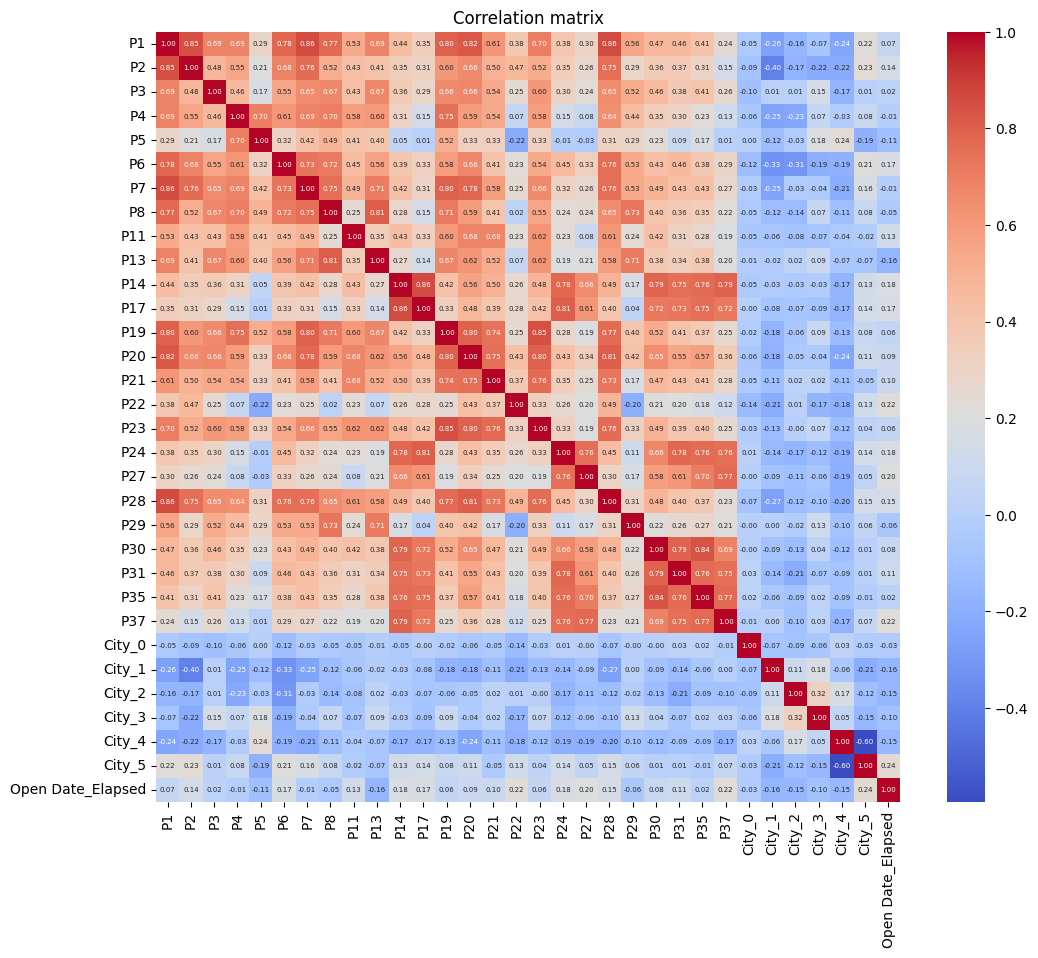

In [ ]:
numeric_columns = X_train.select_dtypes(include=['float64', 'int64']).columns
correlation_matrix = X_train[numeric_columns].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", annot_kws={'size': 5})
plt.title("Correlation matrix")
plt.show()

# Training and forecasting

In [ ]:
X_train = X_train.astype('float64')
X_train = X_train.to_numpy()  # Converting a DataFrame to a numpy array
y_train = y_train.to_numpy().reshape(-1, 1)  # Converting Series to a numpy array and changing the shape
X_test = X_test.astype('float64')

nn = CustomNeuralNetwork(X_train.shape[1], 50, 1, learning_rate=0.01, epochs=1001)
nn.fit(X_train, y_train)

y_pred_nn = nn.predict(X_test)

rmse_nn_test = calculate_rmse(y_test, y_pred_nn)
print(f"RMSE for a custom neural network on test data: {rmse_nn_test:.4f}")

Epoch 0, Loss: 227.55454081231602
Epoch 100, Loss: 201.37280402903906
Epoch 200, Loss: 201.37280402903906
Epoch 300, Loss: 201.37280402903906
Epoch 400, Loss: 201.37280402903906
Epoch 500, Loss: 201.37280402903906
Epoch 600, Loss: 201.37280402903906
Epoch 700, Loss: 201.37280402903906
Epoch 800, Loss: 201.37280402903906
Epoch 900, Loss: 201.37280402903906
Epoch 1000, Loss: 201.37280402903906
RMSE for a custom neural network on test data: 14.2135


Training RandomForest...
RandomForest RMSE: 0.5025
Training XGBoost...
XGBoost RMSE: 0.4793
Training LightGBM...
LightGBM RMSE: 0.4956
Training CatBoost...
CatBoost RMSE: 0.4846
Training CustomNeuralNetwork...
CustomNeuralNetwork RMSE: 14.2135

Model Performance:
----------------------------------------
Model: RandomForest, RMSE: 0.5025
Model: XGBoost, RMSE: 0.4793
Model: LightGBM, RMSE: 0.4956
Model: CatBoost, RMSE: 0.4846
Model: CustomNeuralNetwork, RMSE: 14.2135
----------------------------------------


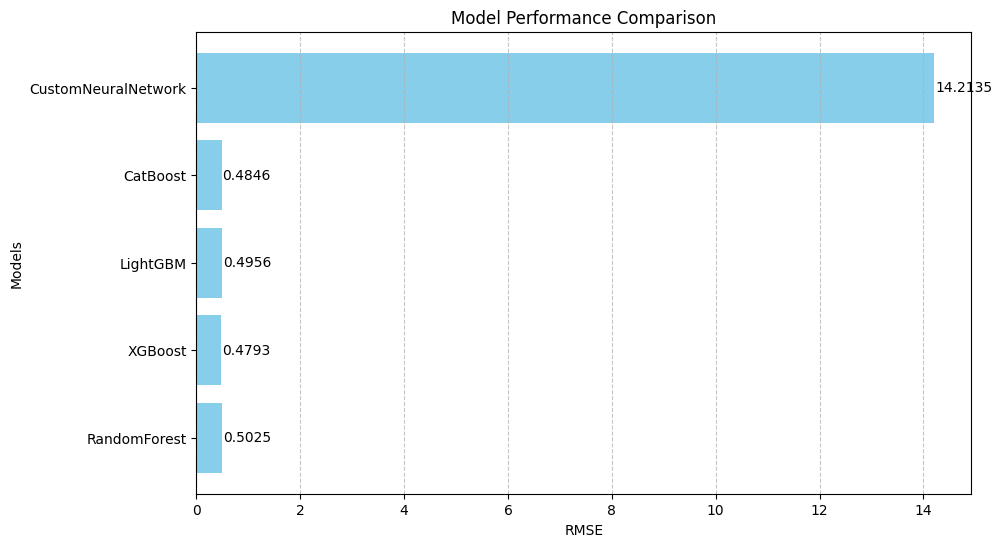

In [ ]:
def evaluate_models(models, X_train, y_train, X_test, y_test, custom_model=None, custom_model_name="CustomModel"):
    results = {}

    for name, model in models:
        print(f"Training {name}...")
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        results[name] = rmse
        print(f"{name} RMSE: {rmse:.4f}")

    if custom_model:
        print(f"Training {custom_model_name}...")
        rmse_custom = np.sqrt(mean_squared_error(y_test, y_pred_nn))
        results[custom_model_name] = rmse_custom
        print(f"{custom_model_name} RMSE: {rmse_custom:.4f}")

    analyze_results(results)

def analyze_results(results):
    model_names = list(results.keys())
    rmse_values = list(results.values())

    print("\nModel Performance:")
    print("-" * 40)
    for name, rmse in results.items():
        print(f"Model: {name}, RMSE: {rmse:.4f}")
    print("-" * 40)

    plt.figure(figsize=(10, 6))
    bars = plt.barh(model_names, rmse_values, color='skyblue')
    plt.xlabel("RMSE")
    plt.ylabel("Models")
    plt.title("Model Performance Comparison")
    plt.grid(axis='x', linestyle='--', alpha=0.7)

    for bar, value in zip(bars, rmse_values):
        plt.text(
            bar.get_width() + 0.01,
            bar.get_y() + bar.get_height() / 2,
            f"{value:.4f}",
            va='center',
            fontsize=10,
            color='black'
        )

    plt.show()


evaluate_models(
    model_list,
    X_train, y_train,
    X_test, y_test,
    custom_model=nn,
    custom_model_name="CustomNeuralNetwork"
)


In [ ]:
rf_model_list = [
    ("RandomForest", RandomForestRegressor(n_jobs=-1, n_estimators=150, oob_score=True, max_features=0.5))
]

In [ ]:
results_rf = train_cv(X_train, y_train, rf_model_list)
best_model_rf_name, (best_models_rf, rmse_rf) = min(results_rf.items(), key=lambda x: x[1][1])
y_pred_rf = best_models_rf[0].predict(X_test)
print(f"RMSE for model 1 (Random Forest): {rmse_rf}")

Training model: RandomForest
Model RandomForest: Mean RMSE = 0.4248
RMSE for model 1 (Random Forest): 0.42477927012690864


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


In [ ]:
results_model_list = train_cv(X_train, y_train, model_list)
best_model_list_name, (best_models_list, rmse_list) = min(results_model_list.items(), key=lambda x: x[1][1])
y_pred_list = best_models_list[0].predict(X_test)
print(f"RMSE for model 2 (CV): {rmse_list}")

Training model: RandomForest
Model RandomForest: Mean RMSE = 0.4209
Training model: XGBoost
Model XGBoost: Mean RMSE = 0.4556
Training model: LightGBM


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10

Model LightGBM: Mean RMSE = 0.4889
Training model: CatBoost
Model CatBoost: Mean RMSE = 0.4432
RMSE for model 2 (CV): 0.4209340289443111


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


In [ ]:
X_train_dummies, X_test_dummies = merge_and_process_data(df_train.copy(), df_test.copy(), fe=['dummies'])
y_train_dummies = df_train['revenue'].copy().apply(np.sqrt).apply(np.log)

results_dummies = train_cv(X_train_dummies, y_train_dummies, model_list)
best_model_dummies_name, (best_models_dummies, rmse_dummies) = min(results_dummies.items(), key=lambda x: x[1][1])
y_pred_dummies = best_models_dummies[0].predict(X_test_dummies)
print(f"RMSE for model 3 (Preprocessing + CV): {rmse_dummies}")

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:411: FutureWarning: The `_get_tags` method is deprecated in 1.6 and will be removed in 1.7. Please implement the `__sklearn_tags__` method.
  warnings.warn(


Training model: RandomForest
Model RandomForest: Mean RMSE = 0.2296
Training model: XGBoost
Model XGBoost: Mean RMSE = 0.2609
Training model: LightGBM
Model LightGBM: Mean RMSE = 0.2479
Training model: CatBoost


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10

Model CatBoost: Mean RMSE = 0.2322


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


RMSE for model 3 (Preprocessing + CV): 0.22958368148785882


In [ ]:
X_train_scale, X_test_scale = merge_and_process_data(df_train.copy(), df_test.copy(), fe=['id', 'dummies', 'scale_open'])
y_train_scale = df_train['revenue'].copy().apply(np.sqrt).apply(np.log)

results_scale = train_cv(X_train_scale, y_train_scale, model_list)
best_model_scale_name, (best_models_scale, rmse_scale) = min(results_scale.items(), key=lambda x: x[1][1])
y_pred_scale = best_models_scale[0].predict(X_test_scale)
print(f"RMSE for model 4 (Preprocessing + CV): {rmse_scale}")

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:411: FutureWarning: The `_get_tags` method is deprecated in 1.6 and will be removed in 1.7. Please implement the `__sklearn_tags__` method.
  warnings.warn(


Training model: RandomForest
Model RandomForest: Mean RMSE = 0.2296
Training model: XGBoost
Model XGBoost: Mean RMSE = 0.2609
Training model: LightGBM


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10

Model LightGBM: Mean RMSE = 0.2479
Training model: CatBoost
Model CatBoost: Mean RMSE = 0.2322


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


RMSE for model 4 (Preprocessing + CV): 0.22958368148785874


In [ ]:
X_train_city, X_test_city = merge_and_process_data(df_train.copy(), df_test.copy(), fe=['id', 'dummies', 'city'])
y_train_city = df_train['revenue'].copy().apply(np.sqrt).apply(np.log)

results_city = train_cv(X_train_city, y_train_city, model_list)
best_model_city_name, (best_models_city, rmse_city) = min(results_city.items(), key=lambda x: x[1][1])
y_pred_city = best_models_city[0].predict(X_test_city)
print(f"RMSE for model 5 (Preprocessing + CV): {rmse_city}")

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:411: FutureWarning: The `_get_tags` method is deprecated in 1.6 and will be removed in 1.7. Please implement the `__sklearn_tags__` method.
  warnings.warn(


Training model: RandomForest
Model RandomForest: Mean RMSE = 0.2296
Training model: XGBoost
Model XGBoost: Mean RMSE = 0.2609
Training model: LightGBM
Model LightGBM: Mean RMSE = 0.2479
Training model: CatBoost


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10

Model CatBoost: Mean RMSE = 0.2322


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


RMSE for model 5 (Preprocessing + CV): 0.22958368148785877


In [ ]:
X_train_open, X_test_open = merge_and_process_data(df_train.copy(), df_test.copy(), fe=['scale_open'])
y_train_open = df_train['revenue'].copy().apply(np.sqrt).apply(np.log)

results_open = train_cv(X_train_open, y_train_open, model_list)
best_model_open_name, (best_models_open, rmse_open) = min(results_open.items(), key=lambda x: x[1][1])
y_pred_open = best_models_open[0].predict(X_test_open)
print(f"RMSE for model 6 (Preprocessing + CV): {rmse_open}")


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:411: FutureWarning: The `_get_tags` method is deprecated in 1.6 and will be removed in 1.7. Please implement the `__sklearn_tags__` method.
  warnings.warn(


Training model: RandomForest
Model RandomForest: Mean RMSE = 0.2223
Training model: XGBoost
Model XGBoost: Mean RMSE = 0.2390
Training model: LightGBM


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10

Model LightGBM: Mean RMSE = 0.2345
Training model: CatBoost
Model CatBoost: Mean RMSE = 0.2311


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


RMSE for model 6 (Preprocessing + CV): 0.22228921198251567


# Evaluation of models

In [ ]:
def analyze_results(results):
    model_names = []
    mean_rmse_values = []

    for model_name, (models, mean_rmse) in results.items():
        print(f"Model: {model_name}")
        print(f"Number of models (folds): {len(models)}")
        print(f"Mean RMSE: {mean_rmse:.4f}")
        print("-" * 40)

        model_names.append(model_name)
        mean_rmse_values.append(mean_rmse)
    plt.figure(figsize=(10, 6))
    plt.barh(model_names, mean_rmse_values, color='skyblue')
    plt.xlabel("Mean RMSE")
    plt.ylabel("Models")
    plt.title("Model performance")
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.show()

Model: RandomForest
Number of models (folds): 4
Mean RMSE: 0.2223
----------------------------------------
Model: XGBoost
Number of models (folds): 4
Mean RMSE: 0.2390
----------------------------------------
Model: LightGBM
Number of models (folds): 4
Mean RMSE: 0.2345
----------------------------------------
Model: CatBoost
Number of models (folds): 4
Mean RMSE: 0.2311
----------------------------------------


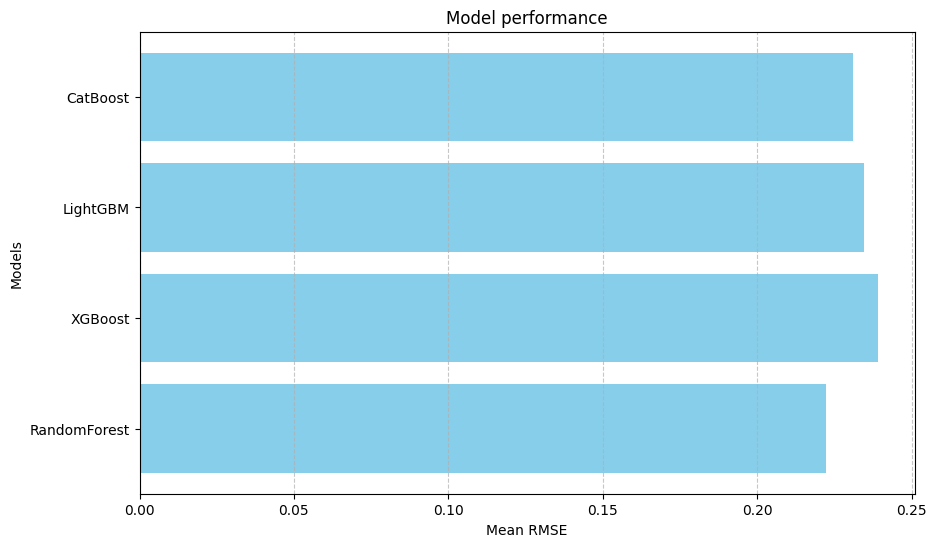

In [ ]:
analyze_results(results_open)

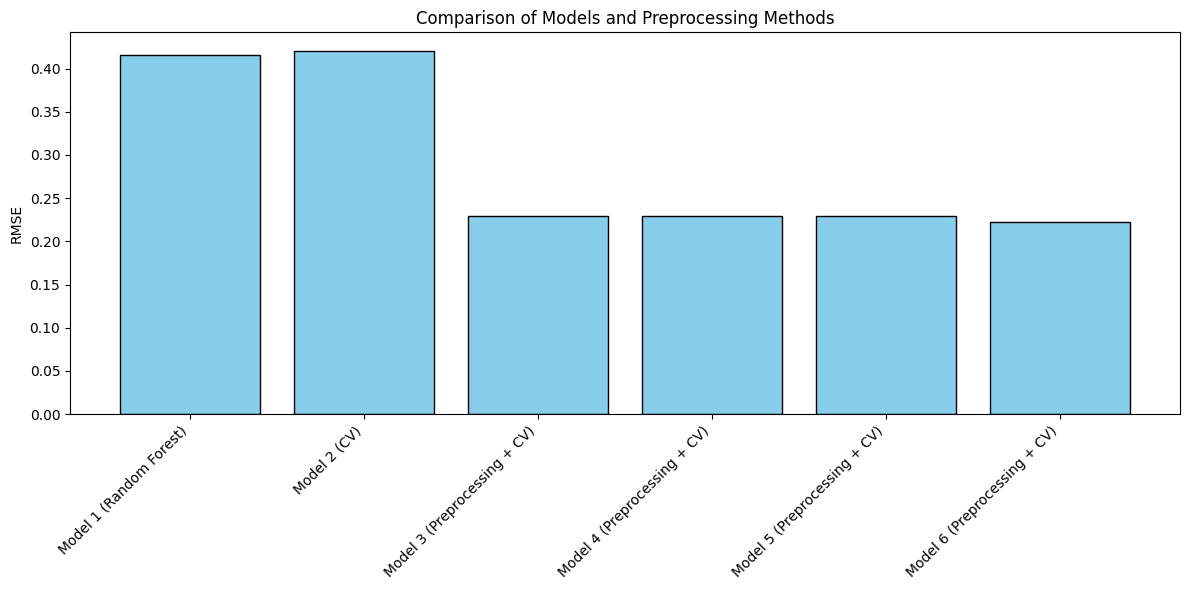

In [ ]:
experiments = [
    {"name": "Model 1 (Random Forest)", "rmse": rmse_rf},
    {"name": "Model 2 (CV)", "rmse": rmse_list},
    {"name": "Model 3 (Preprocessing + CV)", "rmse": rmse_dummies},
    {"name": "Model 4 (Preprocessing + CV)", "rmse": rmse_scale},
    {"name": "Model 5 (Preprocessing + CV)", "rmse": rmse_city},
    {"name": "Model 6 (Preprocessing + CV)", "rmse": rmse_open},
]

names = [exp["name"] for exp in experiments]
rmses = [exp["rmse"] for exp in experiments]

plt.figure(figsize=(12, 6))
plt.bar(names, rmses, color='skyblue', edgecolor='black')
plt.xticks(rotation=45, ha='right')
plt.ylabel("RMSE")
plt.title("Comparison of Models and Preprocessing Methods")
plt.tight_layout()

plt.show()

The best model: Model 6 (Preprocessing + CV + Scale Open Simple) з RMSE = 0.2223
Feature Importance for the best model:
                       Feature  Importance
37         Open Date_Dayofyear    0.115443
44           Open Date_Elapsed    0.114044
34              Open Date_Week    0.065419
21                         P28    0.063078
33              Open Date_Year    0.058423
35               Open Date_Day    0.046790
2                           P1    0.036608
36         Open Date_Dayofweek    0.034671
15                         P20    0.030706
14                         P19    0.029723
22                         P29    0.028090
7                           P6    0.026514
32                      City_5    0.025598
13                         P17    0.024385
17                         P22    0.024130
10                         P11    0.023127
3                           P2    0.021251
11                         P13    0.016193
9                           P8    0.016106
18                  

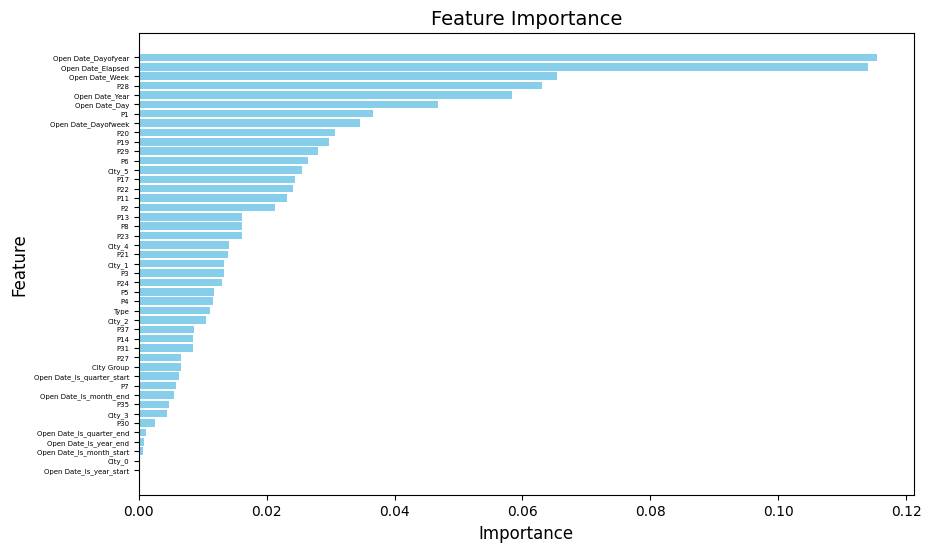

In [ ]:
all_results = {
    "Model 1 (Random Forest)": (best_models_rf[0], rmse_rf),
    "Model 2 (CV)": (best_models_list[0], rmse_list),
    "Model 3 (Preprocessing + CV + Dummies)": (best_models_dummies[0], rmse_dummies),
    "Model 4 (Preprocessing + CV + Scale Open)": (best_models_scale[0], rmse_scale),
    "Model 5 (Preprocessing + CV + City)": (best_models_city[0], rmse_city),
    "Model 6 (Preprocessing + CV + Scale Open Simple)": (best_models_open[0], rmse_open)
}

best_model_name, (best_model, best_rmse) = min(all_results.items(), key=lambda x: x[1][1])

print(f"The best model: {best_model_name} з RMSE = {best_rmse:.4f}")
if hasattr(best_model, "feature_importances_"):
    importances = best_model.feature_importances_
    feature_names = X_train.columns
    feature_importance = pd.DataFrame({
        "Feature": feature_names,
        "Importance": importances
    }).sort_values(by="Importance", ascending=False)

    print("Feature Importance for the best model:")
    print(feature_importance)

    plt.figure(figsize=(10, 6))
    plt.barh(feature_importance["Feature"], feature_importance["Importance"], color="skyblue")
    plt.xlabel("Importance", fontsize=12)
    plt.ylabel("Feature", fontsize=12)
    plt.title("Feature Importance", fontsize=14)
    plt.gca().invert_yaxis()
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=5)
    plt.show()